Stitching image 1 of 3
Stitching image 2 of 3
Stitching image 3 of 3
Panorama creation complete.
Output saved as panorama_result.pdf and matching_points.pdf


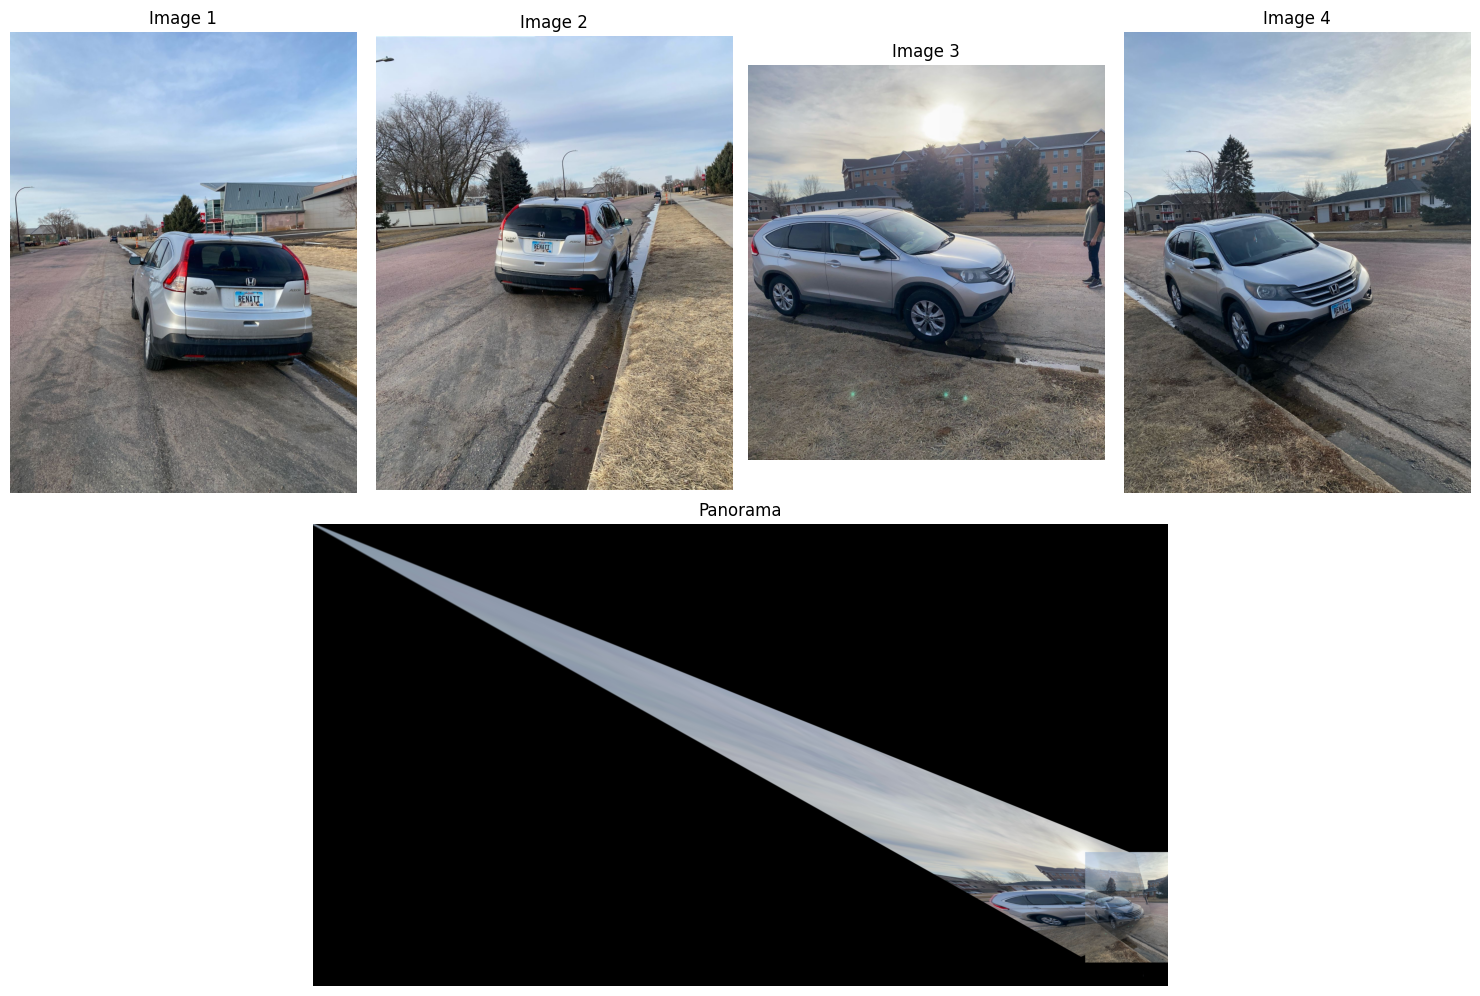

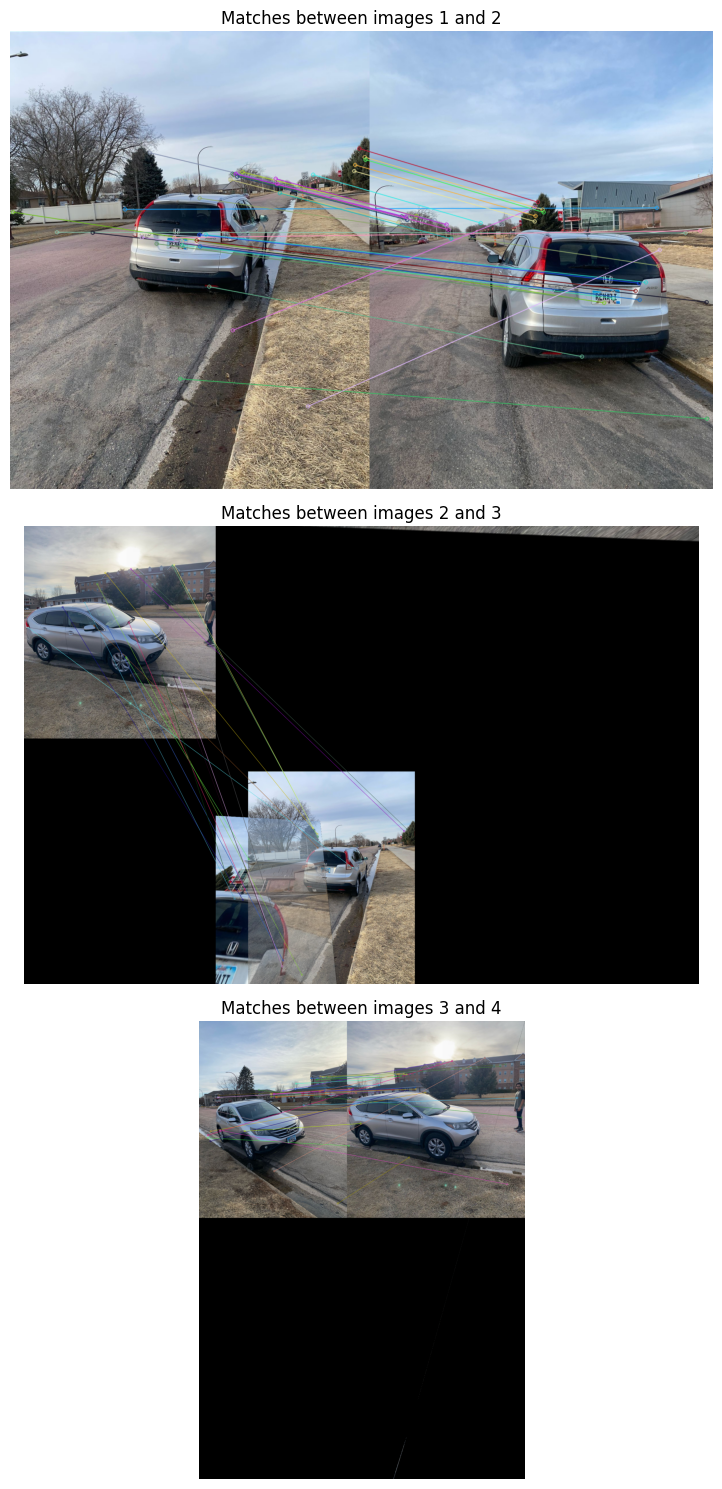

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os

def get_matching_points(img1, img2, ratio=0.75, reprojThresh=4.0):
    """Find matching points between two images using SIFT."""
    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    
    # Detect keypoints and extract descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    
    # Create matcher and match descriptors
    bf = cv2.BFMatcher()
    raw_matches = bf.knnMatch(des1, des2, k=2)
    
    # Apply Lowe's ratio test to filter good matches
    good_matches = [m for m, n in raw_matches if m.distance < ratio * n.distance]
    
    # Visualize matches
    matches_image = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, 
                                     flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # If not enough matches, return None
    if len(good_matches) < 4:
        return None, None, matches_image
    
    # Extract matched keypoints
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Compute homography using RANSAC
    M, status = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, reprojThresh)
    
    return M, status, matches_image

def stitch_images(img1, img2, M):
    """Stitch two images together using the computed homography matrix."""
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    
    # Warp img1 to align with img2
    pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(4, 1, 2)
    
    # Check if M is valid
    if M is None:
        print("Warning: Homography matrix is None. Cannot stitch images.")
        return img1  # Return the first image if stitching cannot be performed
    
    pts2 = cv2.perspectiveTransform(pts1, M)
    
    # Get dimensions of the stitched image
    pts = np.concatenate((pts2, np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(4, 1, 2)), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    
    translation_dist = [-xmin, -ymin]
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
    
    output_img = cv2.warpPerspective(img1, H_translation.dot(M), (xmax - xmin, ymax - ymin))
    
    img2_offset = np.zeros_like(output_img)
    img2_offset[translation_dist[1]:h2 + translation_dist[1], translation_dist[0]:w2 + translation_dist[0]] = img2
    
    gray1 = cv2.cvtColor(output_img, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2_offset, cv2.COLOR_BGR2GRAY)
    
    ret, mask1 = cv2.threshold(gray1, 1, 255, cv2.THRESH_BINARY)
    ret, mask2 = cv2.threshold(gray2, 1, 255, cv2.THRESH_BINARY)
    
    overlap = cv2.bitwise_and(mask1, mask2)
    non_overlap1 = cv2.bitwise_xor(mask1, overlap)
    non_overlap2 = cv2.bitwise_xor(mask2, overlap)
    
    result = cv2.add(cv2.bitwise_and(output_img, output_img, mask=non_overlap1), 
                     cv2.bitwise_and(img2_offset, img2_offset, mask=non_overlap2))
    
    overlap_region1 = cv2.bitwise_and(output_img, output_img, mask=overlap)
    overlap_region2 = cv2.bitwise_and(img2_offset, img2_offset, mask=overlap)
    
    overlap_blend = cv2.addWeighted(overlap_region1, 0.5, overlap_region2, 0.5, 0)
    
    result = cv2.add(result, overlap_blend)
    
    return result

def stitch_multiple_images(images):
    """Stitch multiple images together."""
    if len(images) < 2:
        return images[0] if images else None
    
    # Start with the first image as the base
    result = images[0]
    
    # Store all match visualizations
    match_visualizations = []
    
    # Iteratively add each subsequent image
    for i in range(1, len(images)):
        print(f"Stitching image {i} of {len(images)-1}")
        img = images[i]
        
        # Get matching points and homography
        M, status, matches_img = get_matching_points(img, result)
        match_visualizations.append(matches_img)
        
        if M is None:
            print(f"Warning: Could not find enough matches between images {i-1} and {i}")
            continue
        
        # Stitch the current image to the result
        result = stitch_images(result, img, M)
    
    return result, match_visualizations

def display_results(images, matches, result):
    """Display original images, matching points, and the final panorama."""
    fig = figure(figsize=(15, 10))
    
    # Display original images
    for i, img in enumerate(images):
        plt.subplot(2, len(images), i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Image {i + 1}")
        plt.axis('off')
    
    # Display the final panorama
    plt.subplot(2, 1, 2)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title("Panorama")
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig("panorama_result.pdf", bbox_inches='tight')
    
    # Display matching visualizations
    if matches:
        fig = figure(figsize=(15, 5 * len(matches)))
        for i, match_img in enumerate(matches):
            plt.subplot(len(matches), 1, i + 1)
            plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Matches between images {i + 1} and {i + 2}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig("matching_points.pdf", bbox_inches='tight')

def load_test_images(image_paths):
    """Load images from specified paths."""
    valid_paths = [path for path in image_paths if os.path.exists(path)]
    
    if not valid_paths:
        print("Warning: No valid image paths found. Using example data.")
        return []
    
    # Load images
    images = []
    for path in valid_paths:
        img = cv2.imread(path)
        if img is not None:
            # Resize for faster processing
            img = cv2.resize(img, (0, 0), fx=0.5, fy=0.5)
            images.append(img)
    
    return images

def main(image_paths):
    # Load images
    images = load_test_images(image_paths)
    
    if not images:
        print("No images to process.")
        return
    
    # Stitch images
    result, matches = stitch_multiple_images(images)
    
    # Display results
    display_results(images, matches, result)
    
    print("Panorama creation complete.")
    print("Output saved as panorama_result.pdf and matching_points.pdf")

if __name__ == "__main__":
    # Example image paths - replace with your actual image paths
    image_paths = [
        "Downloads/img1.jpg",  # Replace with your actual image paths
        "Downloads/img2.jpg",
        "Downloads/Car3.jpg",
        "Downloads/Car4.jpg",
    ]
    main(image_paths)

In [2]:
pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   ------ --------------------------------- 1.3/7.5 MB 7.5 MB/s eta 0:00:01
   ------------------ --------------------- 3.4/7.5 MB 8.4 MB/s eta 0:00:01
   -------------------------------- ------- 6.0/7.5 MB 9.7 MB/s eta 0:00:01
   ---------------------------------------  7.3/7.5 MB 9.3 MB/s eta 0:00:01
   ---------------------------------------- 7.5/7.5 MB 8.4 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------- ----- 1.3/1.5 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 5.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ------------------------ --------------- 1.6/2.6 MB 7.0 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 6.1 MB/s eta 